In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/files'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/files/xray_chest.csv
/content/drive/MyDrive/files/pneumonia/0.dcm
/content/drive/MyDrive/files/pneumonia/0.jpg
/content/drive/MyDrive/files/pneumonia/2.jpg
/content/drive/MyDrive/files/pneumonia/1.jpg
/content/drive/MyDrive/files/pneumonia/1.dcm
/content/drive/MyDrive/files/pneumonia/2.dcm
/content/drive/MyDrive/files/pneumonia/3.dcm
/content/drive/MyDrive/files/pneumonia/3.jpg
/content/drive/MyDrive/files/pneumonia/4.dcm
/content/drive/MyDrive/files/pneumonia/4.jpg
/content/drive/MyDrive/files/hydrothorax/0.jpg
/content/drive/MyDrive/files/hydrothorax/0.dcm
/content/drive/MyDrive/files/hydrothorax/1.dcm
/content/drive/MyDrive/files/hydrothorax/2.dcm
/content/drive/MyDrive/files/hydrothorax/1.jpg
/content/drive/MyDrive/files/hydrothorax/3.jpg
/content/drive/MyDrive/files/hydrothorax/3.dcm
/content/drive/MyDrive/files/hydrothorax/4.dcm
/content/drive/MyDrive/files/hydrothorax/2.jpg
/content/drive/MyDrive/files/hydrothorax/4.jpg
/content/drive/MyDrive/files/sarcoid

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
csv_data = pd.read_csv("/content/drive/MyDrive/files/xray_chest.csv")
csv_data.head()

,dcm,jpg,type
0,/abscess/0.dcm,/abscess/0.jpg,abscess
1,/abscess/1.dcm,/abscess/1.jpg,abscess
2,/abscess/2.dcm,/abscess/2.jpg,abscess
3,/abscess/3.dcm,/abscess/3.jpg,abscess
4,/abscess/4.dcm,/abscess/4.jpg,abscess


In [6]:
csv_data.describe()

,dcm,jpg,type
count,97,97,97
unique,97,97,17
top,/abscess/0.dcm,/abscess/0.jpg,abscess
freq,1,1,9


In [7]:
csv_data.shape

(97, 3)

In [8]:
files_dir = "/content/drive/MyDrive/files"
disease = []
for i,k in enumerate(os.listdir(files_dir)):
    disease.append(k)
    print(i+1,k)

1 xray_chest.csv
2 pneumonia
3 hydrothorax
4 sarcoidosis
5 hydropneumothorax
6 post_inflammatory_changes
7 scoliosis
8 venous_congestion
9 tuberculosis
10 pneumosclerosis
11 post_traumatic_ribs_deformation
12 ards
13 fracture
14 cardiomegaly
15 atherosclerosis_of_the_aorta
16 emphysema
17 atelectasis
18 abscess


In [9]:
csv_data["jpg_path"] = csv_data["jpg"].apply(lambda x : os.path.join(files_dir,x[1:]))
csv_data.head()

,dcm,jpg,type,jpg_path
0,/abscess/0.dcm,/abscess/0.jpg,abscess,/content/drive/MyDrive/files/abscess/0.jpg
1,/abscess/1.dcm,/abscess/1.jpg,abscess,/content/drive/MyDrive/files/abscess/1.jpg
2,/abscess/2.dcm,/abscess/2.jpg,abscess,/content/drive/MyDrive/files/abscess/2.jpg
3,/abscess/3.dcm,/abscess/3.jpg,abscess,/content/drive/MyDrive/files/abscess/3.jpg
4,/abscess/4.dcm,/abscess/4.jpg,abscess,/content/drive/MyDrive/files/abscess/4.jpg


In [10]:
csv_data.drop(["dcm","jpg"],inplace = True, axis = 1)
csv_data.head()

,type,jpg_path
0,abscess,/content/drive/MyDrive/files/abscess/0.jpg
1,abscess,/content/drive/MyDrive/files/abscess/1.jpg
2,abscess,/content/drive/MyDrive/files/abscess/2.jpg
3,abscess,/content/drive/MyDrive/files/abscess/3.jpg
4,abscess,/content/drive/MyDrive/files/abscess/4.jpg


In [11]:
data = csv_data.sample(frac = 1)
data.head()

,type,jpg_path
10,ards,/content/drive/MyDrive/files/ards/1.jpg
2,abscess,/content/drive/MyDrive/files/abscess/2.jpg
5,abscess,/content/drive/MyDrive/files/abscess/5.jpg
31,cardiomegaly,/content/drive/MyDrive/files/cardiomegaly/7.jpg
49,hydropneumothorax,/content/drive/MyDrive/files/hydropneumothorax...


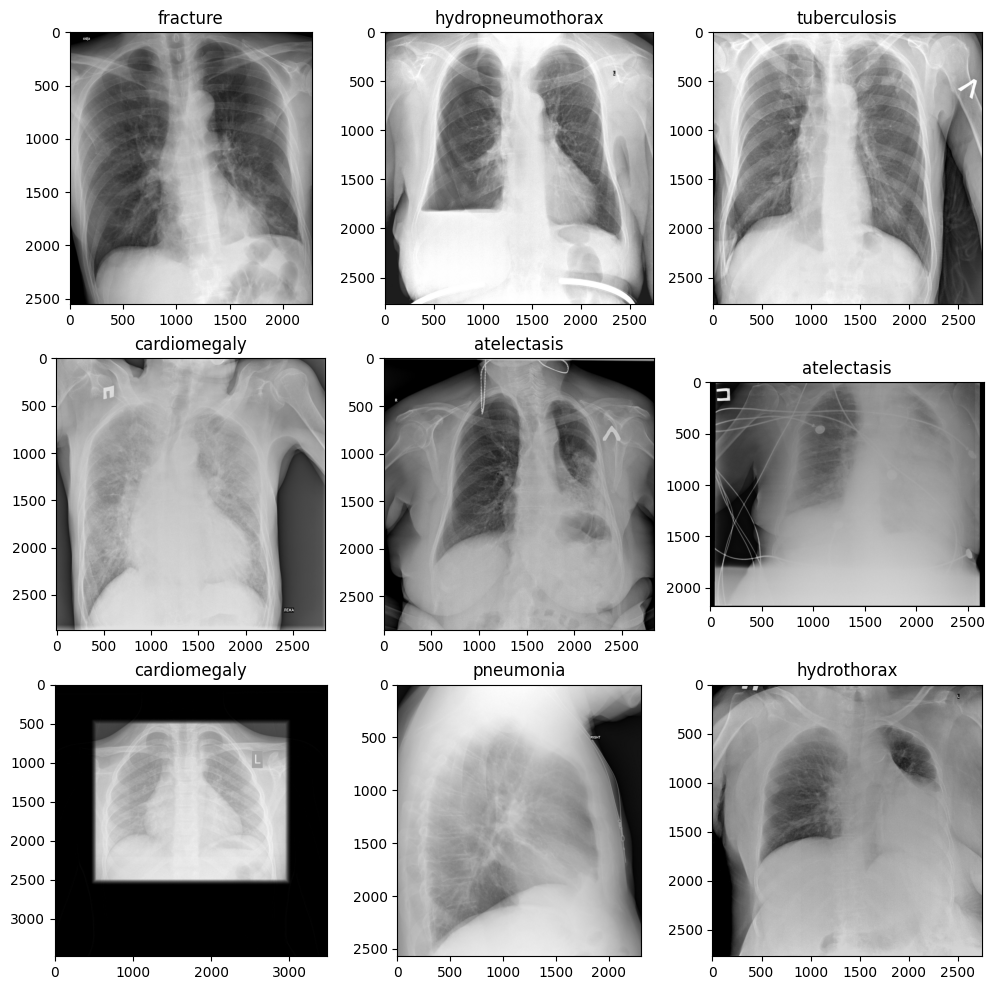

In [12]:
fig = plt.figure(figsize=(12,12))
h,w,r,c = [3]*4
ax=[]
for i in range(1,r*c+1):
    k = np.random.randint(data.shape[0])
    img = image.load_img(data.iloc[k,1])
    ax.append(fig.add_subplot(r,c,i))
    ax[-1].set_title(data.iloc[k,0])
    plt.imshow(img)

plt.show()

In [13]:
from sklearn.model_selection import train_test_split

y,X = data["type"],data["jpg_path"]
#X.head()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, test_size = 0.2)
X_train.head()

,jpg_path
30,/content/drive/MyDrive/files/cardiomegaly/6.jpg
92,/content/drive/MyDrive/files/tuberculosis/4.jpg
43,/content/drive/MyDrive/files/hydropneumothorax...
9,/content/drive/MyDrive/files/ards/0.jpg
93,/content/drive/MyDrive/files/venous_congestion...


In [14]:
train_dataGen = ImageDataGenerator( rescale = 1./255,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  zoom_range = 0.2,
                                    rotation_range = 10,
                                   validation_split = 0.3
                                  )
test_dataGen = ImageDataGenerator(rescale = 1./255)

training_set = train_dataGen.flow_from_dataframe(data,
                                                x_col = "jpg_path",
                                                 y_col = "type",
                                                target_size = (64,64),
                                                 batch_size =32,
                                                class_mode = 'categorical',
                                                 shuffle = True,
                                                 subset="training"
                                                )

validation_set = train_dataGen.flow_from_dataframe(data,
                                                x_col = "jpg_path",
                                                 y_col = "type",
                                                target_size = (64,64),
                                                 batch_size =32,
                                                class_mode = 'categorical',
                                                 shuffle = True,
                                                   subset="validation"
                                                )
testing_set = test_dataGen.flow_from_dataframe(data.sample(frac = 0.2),
                                               x_col = "jpg_path",
                                                 y_col = "type",
                                              target_size = (64,64),
                                              class_mode = 'categorical',
                                               shuffle = False,
                                               batch_size = 32
                                              )

Found 68 validated image filenames belonging to 17 classes.
Found 29 validated image filenames belonging to 17 classes.
Found 19 validated image filenames belonging to 13 classes.


In [15]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',padding="same",input_shape=(64,64,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),activation = 'relu',padding="same",input_shape=(64,64,3)))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=64,activation="relu"))
model.add(Dense(17,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer = 'adam',
             loss='categorical_crossentropy',
             metrics = ['accuracy']
             )

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,215,601 (8.45 MB)

 Trainable params: 2,215,601 (8.45 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(min_delta = 0.0001,
                              patience = 15,
                              restore_best_weights= True)

In [19]:
predict = model.fit(training_set,
                   epochs = 10,
                   steps_per_epoch = 3,
                   validation_data = validation_set
                   )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 10s/step - accuracy: 0.0957 - loss: 2.8548 - val_accuracy: 0.0000e+00 - val_loss: 2.9206
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0910 - loss: 2.8035 - val_accuracy: 0.0000e+00 - val_loss: 2.8919
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0944 - loss: 2.7810 - val_accuracy: 0.0690 - val_loss: 2.8597
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0645 - loss: 2.7884 - val_accuracy: 0.0000e+00 - val_loss: 2.8527
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 996ms/step - accuracy: 0.1023 - loss: 2.7919 - val_accuracy: 0.0000e+00 - val_loss: 2.8606
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0832 - loss: 2.7698 - val_accuracy: 0.0000e+00 - val_loss: 2.9076
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0727 - loss: 2.7186 - val_accuracy: 0.0000e+00 - val_loss: 2.9890
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1448 - loss: 2.7223 - val_accuracy: 0.0000e+00 -

In [20]:
accuracy = model.evaluate(validation_set)
print(accuracy[1]*100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1379 - loss: 3.1927
13.793103396892548


<Axes: >

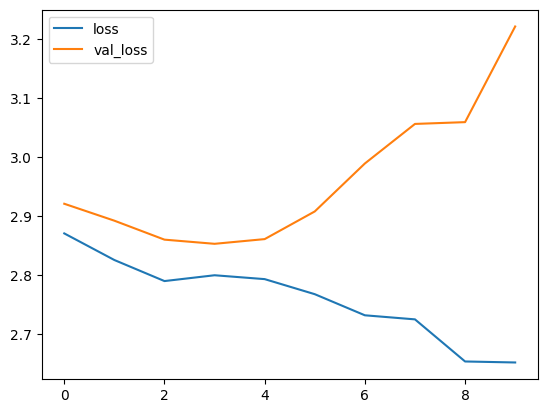

In [21]:
history_df = pd.DataFrame(predict.history)
history_df.loc[:,['loss','val_loss']].plot()

In [22]:
model.save('chest_disease_model.h5')